In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
import os
import cv2


from sklearn.preprocessing import normalize

In [2]:
HOME="/home/spoudel/PR_assignments/assignments_3/Faces_FA_FB/"
fa_H="fa_H"
fa_L="fa_L"
fb_H="fb_H"
fb_L="fb_L"

training_location_H=HOME+"/"+fa_H
testing_location_H=HOME+"/"+fb_H
training_location_L=HOME+"/"+fa_L
testing_location_L=HOME+"/"+fb_L

In [3]:
def get_images_id(location):
    images_name=[]
    for file in os.listdir(location):
        if file.endswith(".pgm"):
            images_name.append(file)

    data_id=np.array([x[:5] for x in images_name])
    images=np.array([cv2.imread(location+"/"+x) for x in images_name])
    return images,data_id

training_images_H,training_data_id_H=get_images_id(training_location_H)
testing_images_H,testing_data_id_H=get_images_id(testing_location_H)
training_images_L,training_data_id_L=get_images_id(training_location_L)
testing_images_L,testing_data_id_L=get_images_id(testing_location_L)

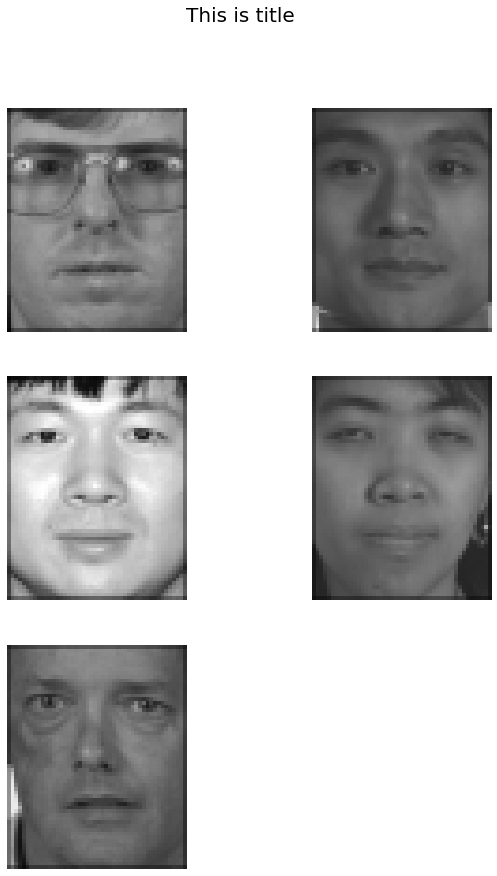

In [4]:
def show_multiple_images(images,title=None):
    rows=len(images)/2
    if rows%1>0:
        rows=rows+1
    columns=2
    fig = plt.figure(figsize=(5*columns,4*rows))
    if title:
        fig.suptitle(title,fontsize=20)
    
    for i in range(len(images)):
        # Adds a subplot at the 1st position
        fig.add_subplot(rows, columns, i+1)
        # showing image
        plt.imshow(images[i],cmap="gray")
        plt.axis('off')
        
show_multiple_images(training_images_H[:5]/255,"This is title")

In [5]:
class MyPCA:
    
    def __init__(self, information=None,n_components=10):
        self.n_components = n_components   
        self.information = information
        
    def find_components(self, input_data):        
        # Standardize data 
        X = input_data.copy()
        self.mean = np.mean(X[:,:,:,0], axis = 0)  
        
        image_shape=X[0,:,:,0].shape
        eigen_values=[]
        eigen_vectors=[]
        
        data=np.array([(image[:,:,0]-self.mean).flatten() for image in X]).T
        trick_cov_mat = np.matmul(data.T,data)
        
        eig_vals, eig_vecs = np.linalg.eigh(trick_cov_mat) 
        eig_vecs=np.matmul(data,eig_vecs)
        
        eig_vecs=np.array([v/ np.linalg.norm(v) for v in eig_vecs.T])   ## Converting to unit length
        
        eig_pairs=[(np.abs(eig_vals[i]),eig_vecs[i]) for i in range(len(eig_vals))]
        
        eig_pairs.sort(key=lambda x: x[0], reverse=True)
        eig_vals_sorted = np.array([x[0] for x in eig_pairs])
        eig_vecs_sorted = np.array([x[1] for x in eig_pairs])
        
        #Finding n_components from teh amount of information to take
        if self.information>1:
            self.information=self.information/100
        if self.information!=None:
            info_cumsum=np.cumsum(eig_vals_sorted)
            
            info_cumsum_percent=np.array(info_cumsum)/info_cumsum[-1]
            for i in range(len(info_cumsum)):
                if info_cumsum_percent[i]>=self.information:
                    self.n_components=i
                    break
                    
        self.components = eig_vecs_sorted[:self.n_components]
        print("Number of components",self.components.shape)
        largest_eigenfaces=eig_vecs_sorted[:10]
        smallest_eigenfaces=eig_vecs_sorted[-10:]
        reshape_to=np.append(10,image_shape)
        return self.mean.reshape(image_shape),largest_eigenfaces.reshape(reshape_to),smallest_eigenfaces.reshape(reshape_to)      
        
    def save_items_transformations(self,input_data):
        X=input_data.copy()
        X=np.array([(image[:,:,0]-self.mean).flatten() for image in X])
        self.projections=np.matmul(X,self.components.T)        
        
    def fit(self,input_data,data_id):
        self.data_id=data_id
        mean,largest_eigenfaces,smallest_eigenfaces=self.find_components(input_data)
        self.save_items_transformations(input_data)
        return mean,largest_eigenfaces,smallest_eigenfaces
    
    def distance_with_faces(self,x):
        distances=np.array([np.linalg.norm(a-x) for a in self.projections])
        return distances
        
    def predict_a_face(self, item, r):
        P = item[:,:,0].copy()
        P = (P - self.mean).flatten()
        P_proj=self.components.dot(P)
        
        distances=self.distance_with_faces(P_proj)
        sorted_arg=np.argsort(distances)
        args_to_see=sorted_arg[:r]
        return np.array([self.data_id[x] for x in args_to_see])
 
    
    def getMean(self):
        return self.mean
    
    def getComponents(self):
        return self.components
    
    def getProjections(self):
        return self.projections

Number of components (3, 2880)


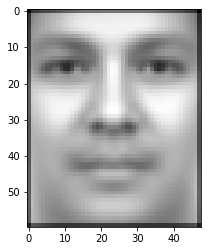

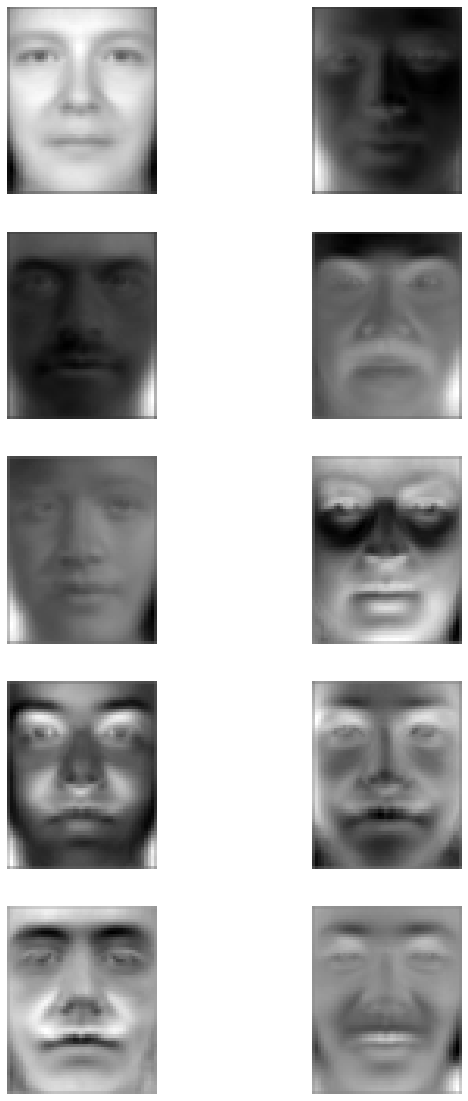

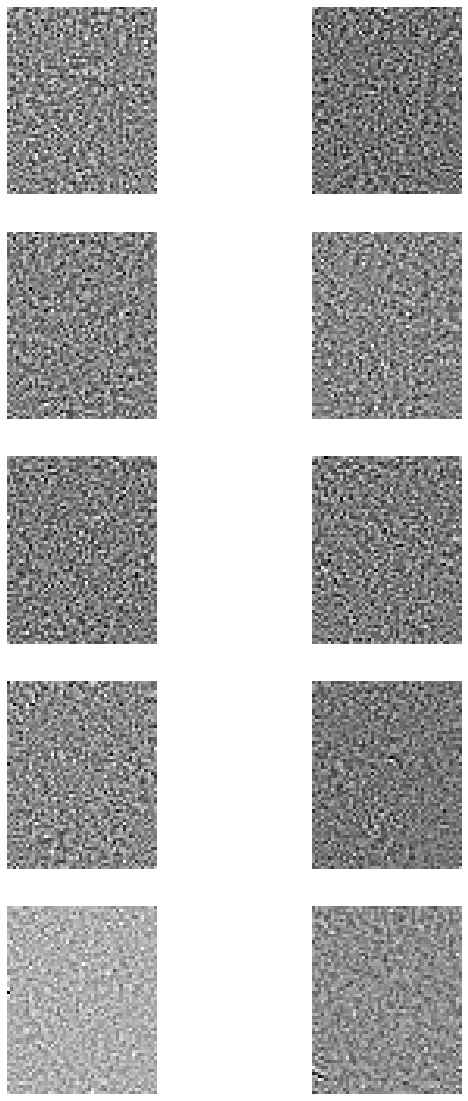

In [6]:
PCA1=MyPCA(information=60)
mean,largest_eigenfaces,smallest_eigenfaces=PCA1.fit(training_images_H,training_data_id_H)
projections=PCA1.getProjections()
plt.imshow(mean,cmap="gray")
show_multiple_images(largest_eigenfaces/255)
show_multiple_images(smallest_eigenfaces/255)

In [7]:
print(training_data_id_H[100])
predictions=PCA1.predict_a_face(training_images_H[0],15)
predictions,training_data_id_H

00602


(array(['00476', '00799', '00512', '00523', '00522', '00521', '00983',
        '00016', '00499', '01011', '00989', '00475', '00927', '00949',
        '00924'], dtype='<U5'),
 array(['00476', '00611', '00029', ..., '00790', '00877', '00465'],
       dtype='<U5'))

In [8]:
def find_accuracy_r(model,r,images,data_id):
    predictions_all=np.array([model.predict_a_face(image,r) for image in images])
    correct_prediction_inside_r_train=np.sum(np.array([1 if data_id[i] in predictions_all[i] else 0 for i in range(len(data_id))]))
    return correct_prediction_inside_r_train/len(images)

find_accuracy_r(PCA1,1,training_images_H,training_data_id_H)

1.0

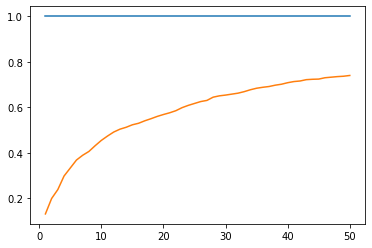

In [9]:
def plot_CMC_curve(model,images,data_id):
    x=np.arange(1,51,1)
    y=np.array([find_accuracy_r(model,i,images,data_id) for i in x])
    plt.plot(x,y)
    return x,y

    
train_x,train_y=plot_CMC_curve(PCA1,training_images_H,training_data_id_H)
test_x,test_y=plot_CMC_curve(PCA1,testing_images_H,testing_data_id_H)

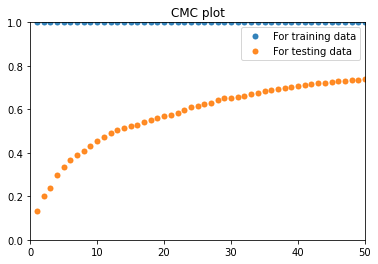

In [10]:
plt.plot(train_x,train_y, '.', alpha=0.9, markersize=10)
plt.plot(test_x,test_y, '.', alpha=0.9, markersize=10)
plt.legend(['For training data', 'For testing data'])
plt.xlim(0,50)
plt.ylim(0,1)
plt.title("CMC plot")
plt.show()

In [11]:
def find_three_right_three_wrong(model,training_images,training_data_id,images,data_id,r):
    predictions_all=np.array([model.predict_a_face(image,r) for image in images])
    print(data_id[1],predictions_all[1])
    if_correct=np.array([1 if data_id[i] in predictions_all[i] else 0 for i in range(len(data_id))])
    corrects_index=[]
    wrongs_index=[]
    for index,val in enumerate(if_correct):
#         print(val)
        if val==1:
            corrects_index.append(index)
        else:
            wrongs_index.append(index)
    correct_image_pairs=np.array([[images[i],training_images[np.where(training_data_id==predictions_all[i])][0]] for i in corrects_index[:4]])
    wrong_image_pairs=np.array([[images[i],training_images[np.where(training_data_id==predictions_all[i])][0]] for i in wrongs_index[:4]])
    return correct_image_pairs,wrong_image_pairs

correct_image_pairs,wrong_image_pairs=find_three_right_three_wrong(PCA1,
                                                                  training_images_H,
                                                                  training_data_id_H,
                                                                  testing_images_H,
                                                                  testing_data_id_H,
                                                                  1)
                                  

00424 ['00424']


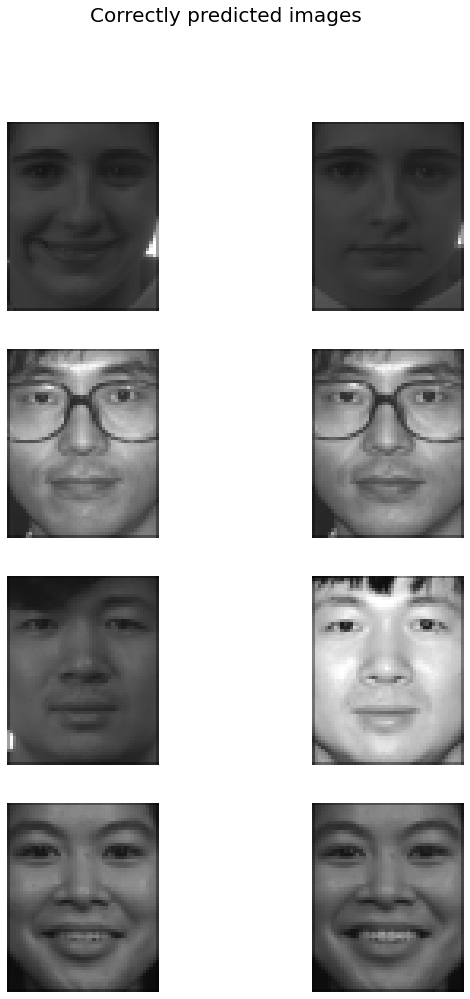

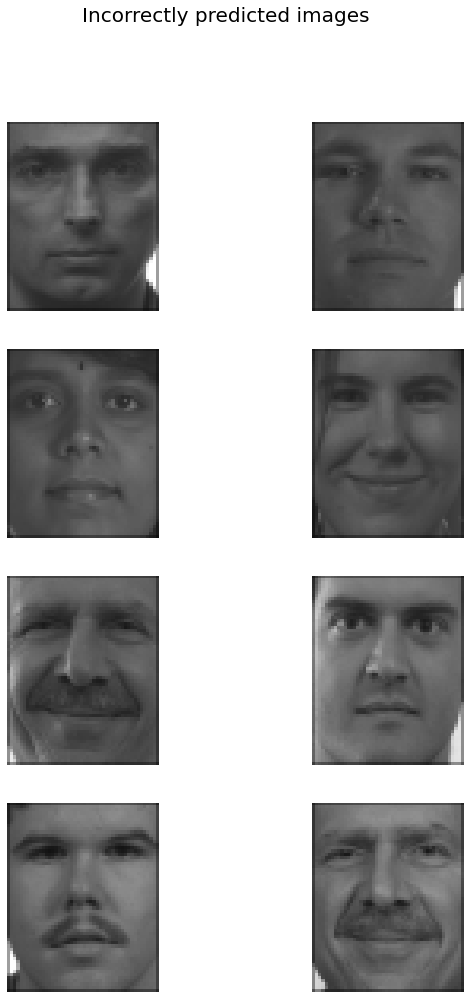

In [12]:
def show_pair_of_images(pair_of_images,title):
    images=[]
    for i in range(len(pair_of_images)):
        images.append(pair_of_images[i][0])
        images.append(pair_of_images[i][1])
    show_multiple_images(images,title)
    
show_pair_of_images(correct_image_pairs,"Correctly predicted images")
show_pair_of_images(wrong_image_pairs,"Incorrectly predicted images")

In [13]:
# predictions_all=np.array([PCA1.predict_a_face(image,1) for image in testing_images_H])
# predictions_all      

In [14]:
def all_question_1a_d(training_images,training_data_id,testing_images,testing_data_id,information):
    model=MyPCA(information=information)
    mean,largest_eigenfaces,smallest_eigenfaces=model.fit(training_images,training_data_id)
    fig = plt.figure(figsize=(5,4))
    plt.imshow(mean,cmap="gray")
    show_multiple_images(largest_eigenfaces/255)
    show_multiple_images(smallest_eigenfaces/255)
    
    correct_image_pairs,wrong_image_pairs=find_three_right_three_wrong(PCA1,
                                                                  training_images,
                                                                  training_data_id,
                                                                  testing_images,
                                                                  testing_data_id,
                                                                  1)
    
    show_pair_of_images(correct_image_pairs,"Correctly predicted images")
    show_pair_of_images(wrong_image_pairs,"Incorrectly predicted images")
    
    
    r_value_train,accuracy_train=plot_CMC_curve(model,training_images,training_data_id)
    r_value_test,accuracy_test=plot_CMC_curve(model
                                              ,testing_images,testing_data_id)
    plt.show()
    
    plt.plot(r_value_train,accuracy_train, '.', alpha=0.9, markersize=10)
    plt.plot(r_value_test,accuracy_test, '.', alpha=0.9, markersize=10)
    plt.legend(['For training data', 'For testing data'])
    plt.xlim(0,50)
    plt.ylim(0,1)
    plt.title(f"CMC plot for {information}% information retention")
    plt.show()
    
    return model


Number of components (15, 2880)
00424 ['00424']


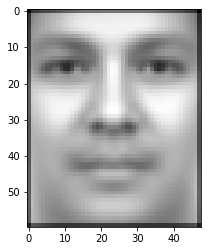

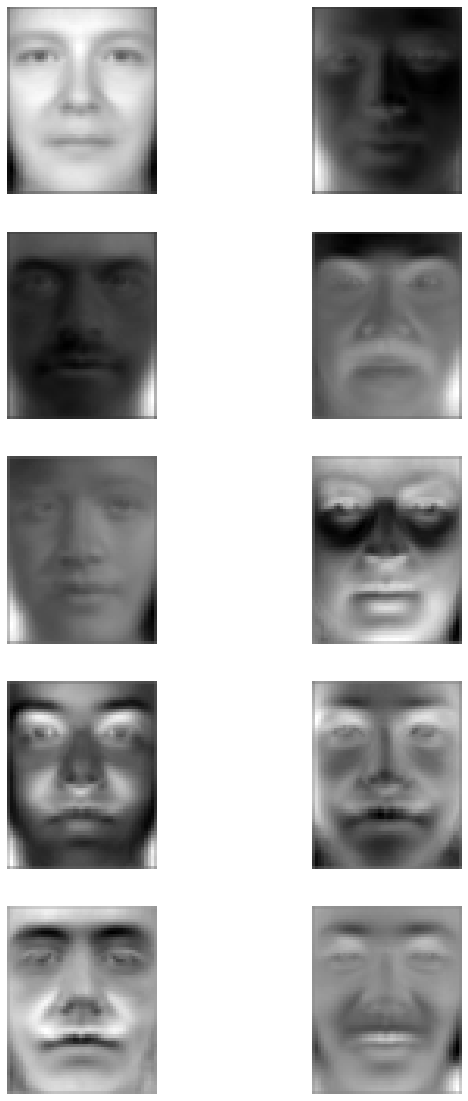

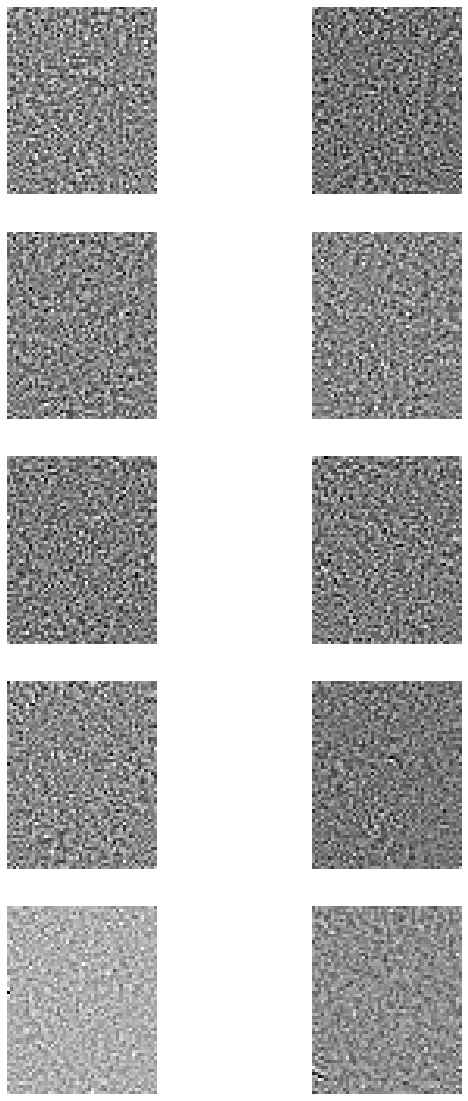

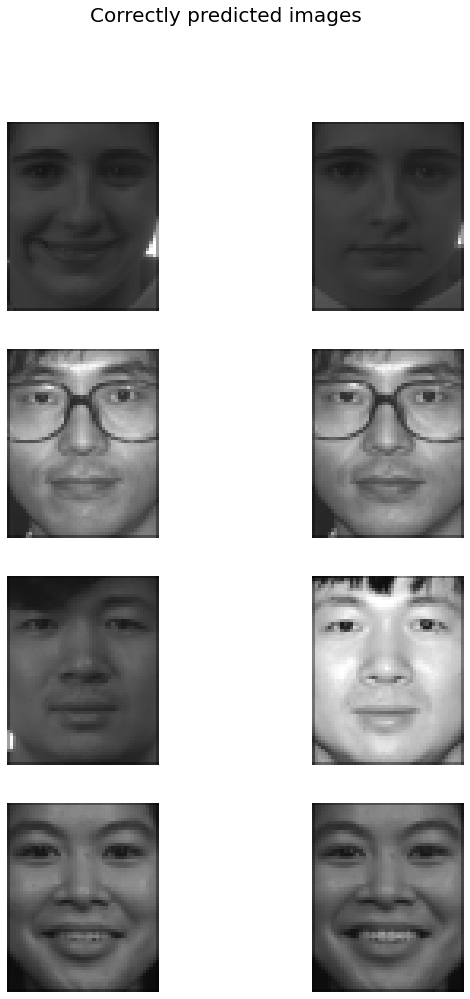

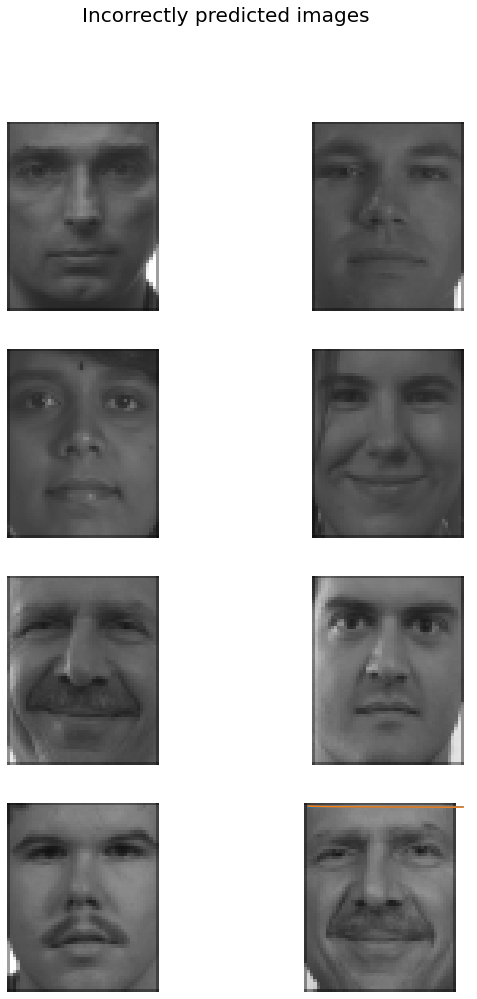

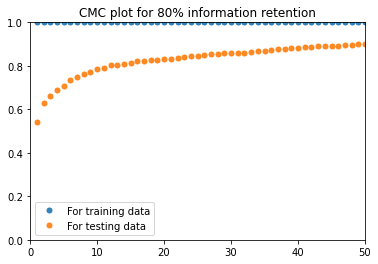

In [15]:
all_question_1a_d(training_images_H,training_data_id_H,testing_images_H,testing_data_id_H,80)

In [ ]:
all_question_1a_d(training_images_H,training_data_id_H,testing_images_H,testing_data_id_H,90)

Number of components (48, 2880)
00424 ['00424']


In [ ]:
all_question_1a_d(training_images_H,training_data_id_H,testing_images_H,testing_data_id_H,95)